# Кислотна денатурація білків

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import peakutils
from BaselineRemoval import BaselineRemoval
plt.style.use('seaborn-whitegrid')

## Зчитування данних

In [2]:
data_dir = 'data'
files = os.listdir(data_dir)

# обираємо тільки файли з роширенням .txt
files = [file for file in files if file.endswith('.txt')]
files.remove('normal.txt')

# створюємо пустий датафрейм з колонками для кожного файлу + одна колонка буде довжинами хвиль
files = [data_dir + '/' + file for file in files]
spect = pd.DataFrame()

# зчитуємо довжини хвиль
f1 = pd.read_csv(files[0], sep='  ', engine='python')
f2 = pd.read_csv(data_dir + '/normal.txt', sep='  ', engine='python')
spect['lambda, nm'] = f1.iloc[:,0]
spect['control'] =  f2.iloc[:,1]

time = []
for idx, path in enumerate(files):
    p = re.compile(r'_\d*m')
    dur = p.search(path).group(0)[1:-1]
    time.append( int(dur) )
    f = pd.read_csv(path, sep='  ', engine='python')
    spect[int(dur)] = f.iloc[:,1]
time = sorted(time)
spect

,"lambda, nm",control,3,30,1,50,40,2,20,25,4,10,60,15,5
0,699.0,0.015,0.130,0.018,0.107,0.015,0.015,0.130,0.122,0.036,0.130,0.194,0.015,0.218,0.137
1,698.0,0.015,0.130,0.018,0.107,0.015,0.015,0.130,0.122,0.036,0.130,0.195,0.015,0.219,0.137
2,697.0,0.015,0.130,0.018,0.107,0.015,0.015,0.130,0.123,0.036,0.130,0.195,0.015,0.219,0.137
3,696.0,0.015,0.131,0.018,0.108,0.016,0.015,0.131,0.123,0.036,0.131,0.196,0.015,0.220,0.138
4,695.0,0.015,0.131,0.018,0.108,0.016,0.015,0.131,0.123,0.036,0.131,0.196,0.015,0.220,0.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,194.0,3.780,4.000,3.081,4.000,3.081,3.780,4.000,3.479,3.178,4.000,4.000,3.002,4.000,4.000
506,193.0,3.708,4.000,3.009,4.000,3.009,3.708,4.000,3.407,3.106,4.000,3.708,3.009,4.000,4.000
507,192.0,4.000,4.000,2.926,4.000,2.926,4.000,4.000,3.324,3.023,4.000,4.000,2.847,4.000,4.000
508,191.0,3.526,4.000,2.827,4.000,2.827,3.526,4.000,3.225,2.924,4.000,4.000,2.827,4.000,3.526


## Тепер знайдемо базові лінії і віднімемо їх

In [3]:
spect_align = spect.copy()
absor_align = BaselineRemoval(np.array(spect_align[60])).ZhangFit(itermax=10**3)
baseline = np.array(spect_align[60]) - absor_align
for col in spect_align.columns[1:]:
    spect_align[col] -= baseline

## Зображуємо спектри поглинання для різного часу денатурації
### 1. Без віднімання базової лінії

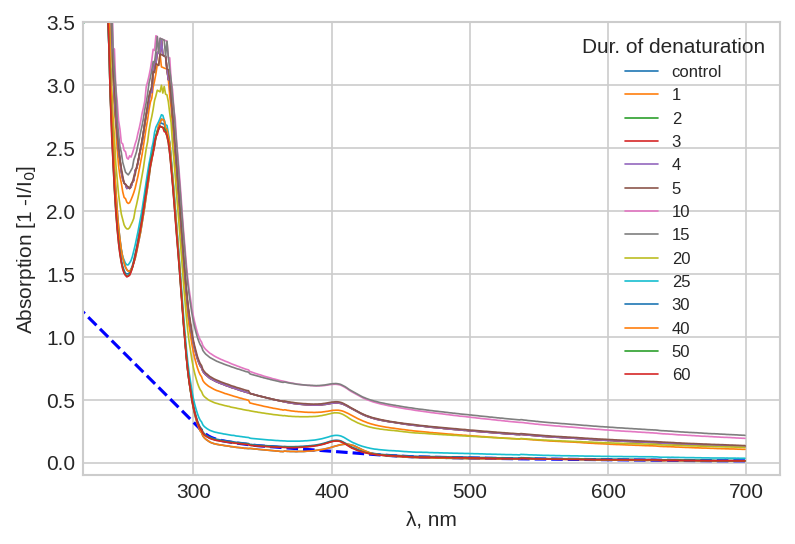

In [4]:
plt.figure(dpi=150);
plt.plot(spect['lambda, nm'], spect['control'], lw=0.8, label='control')
plt.plot(spect['lambda, nm'], baseline, '--b')
for i in time:
    plt.plot(spect['lambda, nm'], spect[i], lw=0.8, label=i)
plt.legend(title='Dur. of denaturation', fontsize=8);
plt.xlabel('λ, nm');
plt.xlim(220, )
plt.ylim(-0.1, 3.5)
plt.ylabel('Absorption [1 -I/I$_0$]');

### 2. З відніманнням базової лінії

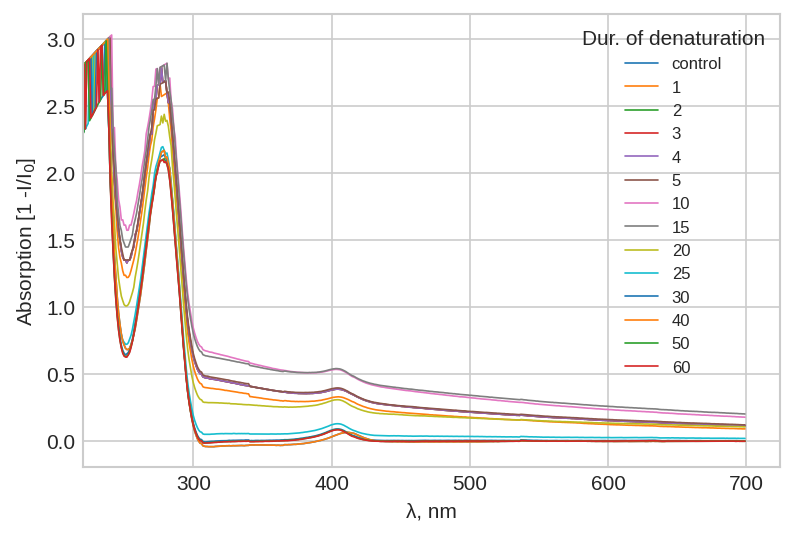

In [5]:
plt.figure(dpi=150);
plt.plot(spect_align['lambda, nm'], spect_align['control'], lw=0.8, label='control')
for i in time:
    plt.plot(spect_align['lambda, nm'], spect_align[i], lw=0.8, label=i)
plt.legend(title='Dur. of denaturation', fontsize=8);
plt.xlabel('λ, nm');
plt.xlim(220, )
#plt.ylim(-0.1, 3.5)
plt.ylabel('Absorption [1 -I/I$_0$]');

## Знаходимо другу похідну

In [6]:
def second_der(x, y):
    x = np.array(x)
    y = np.array(y)
    
    dy = np.diff(y,1)
    dx = np.diff(x,1)

    yfirst = dy/dx
    xfirst = 0.5*(x[:-1]+x[1:])

    dyfirst = np.diff(yfirst,1)
    dxfirst = np.diff(xfirst,1)

    ysecond = dyfirst/dxfirst
    xsecond = 0.5*(xfirst[:-1]+xfirst[1:])
    
    return [xsecond, ysecond]

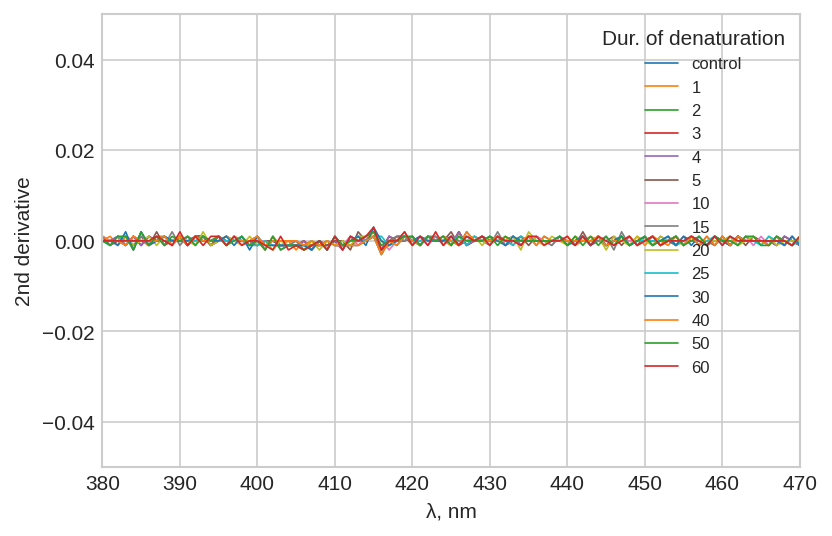

In [7]:
der = second_der(spect['lambda, nm'], spect['control'])

plt.figure(dpi=150)
plt.plot(der[0], der[1], lw=0.8, label='control')
for i in time:
    der = second_der(spect['lambda, nm'],spect[i])
    plt.plot(der[0], der[1], lw=0.8, label=i)
    plt.legend(title='Dur. of denaturation', fontsize=8);
    plt.xlabel('λ, nm');
    plt.xlim(380, 470)
    plt.ylim(-0.05, 0.05)
    plt.ylabel('2nd derivative');

## Базове розсіювання світла
Виділяємо значення поглинання на 330 нм і будуємо графік, де по осі OX - час (хв), по осі OY - поглинання на 330 нм. Таким чином, даний графік продемонструє як
змінювалося базове розсіювання світла при денатурації світла, це розсіювання світла не буде специфічним, тому що в сироватці крові на 330 нм ніщо специфічно не поглинає. **Базову лінію варто залишити, так як в саме міститься багато неспецифічного поглинання**

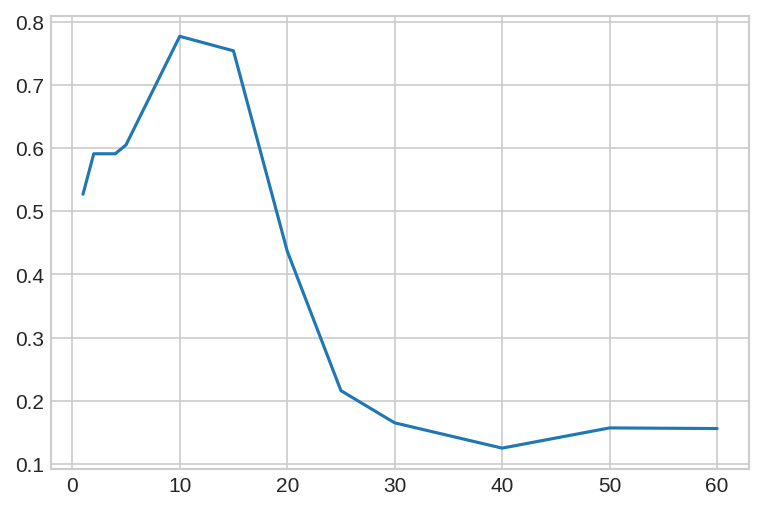

In [57]:
spect
row =  spect.loc[ spect['lambda, nm'] == 330 ].iloc[:,2:]
t_absor = {t:v for t, v in zip(row.columns, row.squeeze())}
t_absor = sorted(t_absor.items(), key=lambda x: x[0])
time, absor = [x[0] for x in t_absor], [x[1] for x in t_absor]
plt.figure(dpi=150)
plt.plot(time, absor)
plt.xlabel('')